# Advanced Risk Management – Assignment 1

**Deadline**:  28 February 2022, 13.00h.

| |Name |Student number|Email|
|:-|:----|:-------------|:----|
|1.|  Yechan Kim|11630655|kkyc1227@naver.com     |
|2.| Jinhyun Kim |11968850|kjin19930000@gmail.com     |
|3.| Victor Poznanski|12287008|victorpoznanski@yahoo.ca     |

****Hand in the following via Canvas****:
* Your notebook.
* A (printed) pdf version of your notebook. In Google Colab, this is most conveniently done in the Chrome browser, and then using the **`File` -> `Print`** menu option; you may have to print in landscape mode to make sure that everything appears in the pdf.
* Files must adhere to the following naming format to be considered eligible: 'Assignment1_STUDENTNUMBER1_STUDENTNUMBER2_STUDENTNUMBER3.ipynb' and 'Assignment1_STUDENTNUMBER1_STUDENTNUMBER2_STUDENTNUMBER3.pdf'. The files and the order of student numbers in the files names must be exactly identical for each member in a team. 


**Notes**:
* The assignment is part of the examination, so the usual rules regarding plagiarism and fraud apply.
* Before submitting your work, click on **`Runtime`-> `Restart and run all ...`** and verify that your notebook produces the desired results and does not error.

**Declaration of Originality**: We, whose names are given under 1., 2., and 3., above declare that these solutions are solely our own work, and that we have not made these solutions available to any other student.

## Introduction
The file `raw_data_2021.xlsx` contains daily data (January 2000 – January 2021, or a sub-period), for a number of international stock market indices, on the closing price and the daily realized variance RV (obtained from 5-minute returns).
A list of the included indices is given on the website of the data provider, see
https://realized.oxford-man.ox.ac.uk/data/assets. In this assignment, you are asked to estimate, test and compare several conditional volatility models for one of the indices in terms of their in-sample fit and their out-of-sample forecast quality.

## Question 1: Load, clean, and display data
First, install and import the relevant libraries:

In [2]:
# !pip install arch             # uncomment for installing the arch package
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

Next, import the data and obtain the returns for all indices. Uncomment and adapt the lines necessary to mount the drive and change the path.

In [3]:
# Read data file

df = pd.read_excel('raw_data_2021.xlsx') # imports the data

Now we transform the data and put the data belonging to our favorite stock index in a DateFrame for further manipulation by running the code below. Pick your favorite index from the list of indices linked to above by adapting the 'Symbol' name below.

In [4]:
df['Date'] = df['Date'].str[0:10] # remove irrelevant parts of date string

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # transform date strings to datetime 
df = df.set_index(['Date']) # set index of DataFrame to the date column

df['R'] = np.log(df['close_price']) - np.log((df['close_price']).shift(1)) # calculate close-to-close returns
df.dropna() # drop N/A entries

sel = df['Symbol']=='.FCHI'   # Boolean array to select index;
                       # change '.ABC' to chosen index symbol, e.g., '.FCHI'
    
R = 100 * (df['R'].loc[sel])['2000-01-04':] # transform returns to percentages (recommended for GARCH package) and remove first row from returns 

RV = 100**2 * (df['rv5'].loc[sel])['2000-01-04':] # transform realized variances as well
RV = RV / RV.mean() / (R**2).mean() # rescale realized variances to account for close-to-open news
RV = RV**0.5 # transform realized variance to realized volatility

Display a line graph of the returns, the realized volatility, and the standardizes returns (the return divided by its realized volatility).  Calculate the skewness and kurtosis of the returns and the standardized returns. Summarize your findings. What can you conclude?

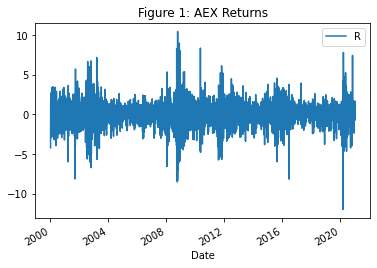

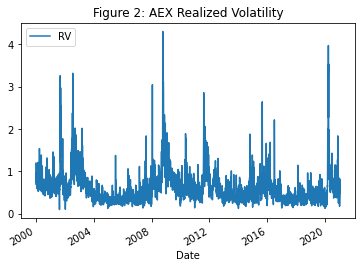

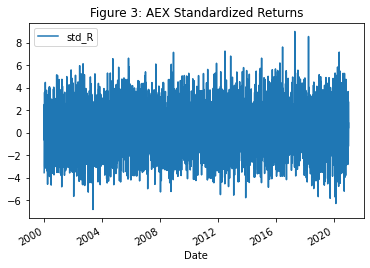

Skewness
Return: -0.22364834900788655 / Standardized returns: 0.17529279573295986
Kurtosis
Return: 5.838868268627145 / Standardized returns: -0.002004169340203532


In [5]:
# line graph of the returns
R.plot()
plt.title('Figure 1: AEX Returns')
plt.legend(['R'])
plt.show()

# the realized volatility
RV.plot()
plt.title('Figure 2: AEX Realized Volatility')
plt.legend(['RV'])
plt.show()

# the standardizes returns (the return divided by its realized volatility)
std_R = R/RV
std_R.plot()
plt.title('Figure 3: AEX Standardized Returns')
plt.legend(['std_R'])
plt.show()

# Calculate the skewness and kurtosis of the returns and the standardized returns. 

# returns the skewness of a series
print("Skewness")
print('Return:',R.skew(),'/ Standardized returns:',std_R.skew())

# returns the excess kurtosis of a series
print("Kurtosis")
print('Return:',R.kurtosis() ,'/ Standardized returns:',std_R.kurtosis())


Discussion of results: [10 pts.]

Q1

The AEX raw returns show the unstable change over time. And the realized volatility is also highly volatile. On the other hand, the AEX standardized returns is more stable with constant upper and lower limits. We can expect that the standardized returns are more reliable and valid result because less outliers and more concentration in the limit imply the normal distributio.

In the next step, we should verify our hypothesis. the Jarque-Bera test will be used to check the significance. 

Jarque-Bera test is designed to test the normality (goodness of fit test). The test statistic for JB test with p = 99.5% is 10.597.
The actual result of the AEX raw return is larger than JB test statistic. (7655.791 > 10.597)
The actual result of the AEX standardized return is larger than JB test statistic. (27.44 > 10.597)
The p values from two types of returns are also significant (p < 0.0)


As a result, both raw and standardized returns are normally distribued. After the result is significant, the smaller value of JB test is more normally distributed. Therefore, the AEX standardized returns are more nomally distributed. 

## Question 2: Fitting a t distribution

It seems the returns have heavy tails. One way of modelling this property is to assume the returns are t distributed. 
1. The code below fits a t ditribution to the data. Fit a t distribution to the data, assuming returns have mean zero. Provide the estimated value of the degrees of freedom parameter $d$ and discuss your result. 
2. Using the formula on Slide 16 of Week 3, estimate the $p$th quantile of the standardized t distribution with degrees of freedom parameter $d$. Use $p=0.01$. Compare this value to the $p$th quantile of the standard normal distribution.
3. If we assume that the volatility is constant over time (an unrealistic assumption, but still one we can make), the quantiles can be used to obtain VaR forecasts for both distributions (see again Slide 16 of Week 3). Obtain the VaR forecasts and compute the percentage of exceedences. Use the standard deviation of the returns to estimate the constant volatility $\sigma$.

Discuss your findings for each step.

In [6]:
# 1
# Fit a t distribution to the data, assuming returns have mean zero. 
d,location,scale = stats.t.fit(R, floc=0) 

# Provide the estimated value of the degrees of freedom parameter $d$ and discuss your result. 
print('Q 2.1')
print('d:', d)
print("")

# 2
# estimate the $p$th quantile of the standardized t distribution with degrees of freedom parameter $d$.
# Use $p=0.01$. Compare this value to the pth quantile of the standard normal distribution.
p=0.01
pquantile_t = np.sqrt((d-2)/d) * stats.t.ppf(p,d,loc=0,scale=1)
print('Q 2.2')
print(f'{int(p*100)}th quantile (standardized t distribution):', pquantile_t)

pquantile_norm = stats.norm.ppf(p)
print(f'{int(p*100)}th quantile (Normal distribution):', pquantile_norm)
print("")

# 3
# Obtain the 'VaR forecasts' and compute the 'percentage of exceedences'. 
# Use the standard deviation of the returns to estimate the constant volatility $\sigma$.
c = np.std(R) # a constantseries / cons_std = R*0 + c
t_p = stats.t.ppf(0.01, d)
VaR_forecast_t = -c*((d-2)/d)**(1/2)*t_p
print('Q 2.3')
print('VaR_forecast (standardized t distribution):', VaR_forecast_t)

c = np.std(R) # a constantseries / cons_std = R*0 + c
VaR_forecast_norm = -c*stats.norm.ppf(p)
print('VaR_forecast (Normal distribution):', VaR_forecast_norm)

hit_series_t = np.where(R < -VaR_forecast_t, 1, 0) # Create a hit series. 1: if R < -VaR_forecast
per_exceed_t = sum(hit_series_t)/len(hit_series_t)   # Calculate the percentage of exceedence.
print('Percentage of exceedence (standardized t distribution):', str(per_exceed_t*100) +'%')

hit_series_norm = np.where(R < -VaR_forecast_norm, 1, 0) # Create a hit series. 1: if R < -VaR_forecast
per_exceed_norm = sum(hit_series_norm)/len(hit_series_norm)   # Calculate the percentage of exceedence.
print('Percentage of exceedence (Normal distribution):', str(per_exceed_norm*100) +'%')


Q 2.1
d: 3.193050091586103

Q 2.2
1th quantile (standardized t distribution): -2.645743277492504
1th quantile (Normal distribution): -2.3263478740408408

Q 2.3
VaR_forecast (standardized t distribution): 3.7747425356071584
VaR_forecast (Normal distribution): 3.319053797647276
Percentage of exceedence (standardized t distribution): 1.3624486748786862%
Percentage of exceedence (Normal distribution): 1.941022769690183%


Discussion of results  [10 pts]:

Q2.1

The estimated value of the degree of freedom is 3.19. This is not sufficiently large to derive the perfect form of the normal distribution. With rounding up to integer, we can regard the degree of freedom is 3. The Student's t distribution with df = 3 has the more excess kurtosis and heavier tail than the normal distribution does.   

Q2.2

The 1th percentile of the standard normal distribution is -2.326. The absolute value of the standard normal distribution is closer to mean zero than the 1th percentile of the t distibution (-2.646). The result proves that the tail of the t distribution is heavier than those of the standard normal distribution.

Q2.3

VaR forecast 3.7747 (t distriution) means 99% confidence that the portfolio will NOT lose more than 3.7747 over the next period. 
The percentage of exceedance (1.36%) means that observed returns worse than minus VaR are 1.36% of the whole portfolio. 

VaR forecast 3.3191 (normal distriution) means 99% confidence that the portfolio will NOT lose more than 3.3191 over the next period. 
The percentage of exceedance (1.94%) means that observed returns worse than minus VaR are 1.94% of the whole portfolio. 

## Question 3: Extreme value theory

We can also use Extreme Value Theory to estimate VaR.

1. The simplest setting uses the formula for VaR on Slide 21 of Week 3: $\text{VaR}^p_{t+1} = \sigma_{t+1} u\bigl( \frac{p}{T_u/T}\bigr)^\xi$, where $u$ denotes the threshold, and $T_u$ denotes the number of losses exceeding the threshold. Use $T_u = 0.05 T$, being 5\% of the total data. Choose $u$ equal to the 95% percentile of the losses. Estimate $\xi$ with the Hill estimator. Describe which observations are used in this method (using the threshold). Also discuss what the estimate of $\xi$ implies.

2. Set $\sigma_{t+1} = \sigma$, for all time periods $t$, and let $\sigma$ denote the value found in Question 2. Obtain an estimate of VaR, at $p=0.01$, and calculate the percentage of exceedences.



In [7]:
# Choose $u$ equal to the 95% percentile of the losses.
loss = R.loc[R<0]  # Should R be here or z should be?
u = -loss.quantile(5/100) # Set threshold.
T = len(R) # obtain length of return series.
Tu = int(np.floor(0.05*T))

# Describe which observations are used in this method (using the threshold). 

# Also discuss what the estimate of $\xi$ implie
# Estimate xi with the Hill estimator. 
x = -R/RV # Here we have used z(=R/RV) as observations.
ysort = np.flipud(np.sort(x)) # Sort observations.
xi_hill = np.mean(np.log(ysort[:Tu-1]/u)) # Tail index
print('Q 3.1')
print('xi :', xi_hill)
print('Here observations are shocks z (= -R/RV). The reason for using this isbecause we need i.i.d obeservations. Hence we did not use R as ovservations ')
print("")

# Obtain an estimate of VaR, at $p=0.01$, and calculate the percentage of exceedences.
p = 0.01 # Set p=0.01
Var_evt = c*u*(p/(Tu/T))**(-xi_hill)
print('Q 3.2')
print('An estimate of VaR, at p=0.01 is', Var_evt)

hit_series_evt = np.where(R < -Var_evt, 1, 0) # Create a hit series. 1: if R < -VaR_forecast
per_exceed_evt = sum(hit_series_evt)/len(hit_series_evt)   # Calculate the percentage of exceedence.
print('Percentage of exceedence (Normal distribution):', str(per_exceed_evt*100) +'%')


Q 3.1
xi : 0.22771484766483668
Here observations are shocks z (= -R/RV). The reason for using this isbecause we need i.i.d obeservations. Hence we did not use R as ovservations 

Q 3.2
An estimate of VaR, at p=0.01 is 6.267849181618921
Percentage of exceedence (Normal distribution): 0.1866368047779022%


Discussion of results [10 pts]:

3.1

The observation used in this method are shocks z (= -R/RV). The reason for using this isbecause we need i.i.d obeservations. Hence, we did not use R as ovservations

xi is 0.2277. This is a positive number, thus implies a heavy tail. However, due to tiny value smaller than one, the tail is not extremely heavy. 

3.2

The estimated VaR 6.2678 at 1%  means 99% confidence that the portfolio will NOT lose more than 6.2678 over the next period. 

The percentage of exceedance (18.66%) means that observed returns worse than minus VaR are 18.66% of the whole portfolio. 

This value (18.66%) is sufficiently risky to the portfolo because 18.66% of returns in the portfolio exceeds the threshold of risk measurement. This implies a high probability of violation or default of the porfolio. 

## Question 4: Adding time-varying volatility
In Question 1 we've found that the standardized returns display no excess kurtosis. The standardization was carried out using ex post realized volatility: We used the realized volatility observed at the end of the day $t$ to standardize the return at the end of time $t$. To use the realized volatility for Value-at-Risk forecasting we must create ex ante forecasts of realized volatility.

1. We use a simple AR model to create Value-at-Risk forecasts. AR models can be estimated using OLS, by regressing the current value of RV on its lag and a constant (Use smf.ols() and don't forget to lag a regressor using d.shift(1).) Plot the ex post RV and its forecast together (Add the forecast to the DataFrame dfregress, dfregress['forecast'] = forecast, and use .plot()). Discuss your findings.

2. Create standardized return shocks (or simply shocks) by dividing the return by the volatility forecast from the AR(1) model and estimate the kurtosis.

3. Estimate VaR forecasts for the shocks using the standardized t distribution, standardized normal distribution and EVT theory. Don't forget to multiply the forecasts by the standard deviation of the shocks, in case of the standardized t and normal distribution. This is important, because the shocks have standard deviation quite far from 1. Then transform the VaR forecasts for shocks to VaR forecasts for returns by multiplying the VaR forecast for shocks by the realized volatility forecast.  Plot the VaR forecasts for the returns together in a plot (You can use the DataFrame trick again). (Note: you must estimate the standard deviation of the shocks when you fit the t distribution, because these shocks might not have standard deviation close to one. The same holds for the normal distribution.)

3. Calculate the percentage of exceedences. Discuss your findings. Also relate your results to ealier questions. Would other tests be more helpful in finding differences between VaR forecasts based on constant volatility and time-varying volatility models?

### Q. 4.1 & Q. 4.2

Kurtosis
Standardized return shocks: 1.057402819556979


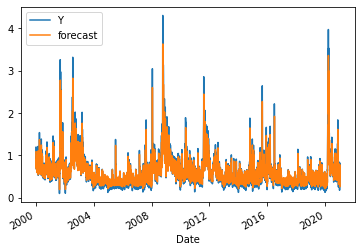

In [8]:
dfregress = pd.DataFrame({'Y': RV})
model = smf.ols('Y ~ Y.shift(1)', data=dfregress) 
result = model.fit()
parametervector = np.array(result.params)
forecast = np.array([RV**0, RV.shift(1)]).transpose().dot(parametervector)
shock = R[1:]/forecast[1:]

dfregress['forecast'] = forecast
dfregress.plot() # Plot

parametervector = np.array(result.params)
forecast = np.array([RV**0, RV.shift(1)]).transpose().dot(parametervector)
shock = R[1:]/forecast[1:] # if we standardize by a forecast we must remove the first value in each series

print("Kurtosis")
print('Standardized return shocks:', shock.kurtosis())

### Q. 4.3

In [9]:
# 3. Estimate VaR forecasts for the shocks  

# the standardized t distribution, 
d_s, location,scale = stats.t.fit(shock, floc=0)  # Fit a t distribution to the data, assuming returns have mean zero. 
v_s = np.std(shock) # volatility of shocks.
t_p = stats.t.ppf(0.01, d_s)
VaR_forecast_t_s = -v_s*((d_s-2)/d_s)**(1/2)*t_p
print('VaR forecasts for shocks (Standardized t distribution):', VaR_forecast_t_s )

# standardized normal distribution 
VaR_forecast_norm_s = -v_s*stats.norm.ppf(0.01)
print('VaR forecasts for shocks (Normal distribution):', VaR_forecast_norm_s )

# EVT theory. 
c_s = np.std(shock)
loss = shock.loc[shock<0] # Choose u equal to the 95% percentile of the losses.
u = -loss.quantile(5/100) # Set threshold.   
T = len(shock) # obtain length of return series.
Tu = int(np.floor(0.05*T))
x = -shock # Set minus shocks as observations
ysort = np.flipud(np.sort(x)) # Sort observations.
xi_hill = np.mean(np.log(ysort[:Tu-1]/u)) # Tail index/ Estimate xi with the Hill estimator.
p = 0.01 # Set p=0.01
VaR_forecast_EVT_s = c_s*u*(p/(Tu/T))**(-xi_hill) # Obtain an estimate of VaR, at $p=0.01$.
print('VaR forecasts for shocks (Extreme Value Theory):',VaR_forecast_EVT_s)


VaR forecasts for shocks (Standardized t distribution): 5.203177331101292
VaR forecasts for shocks (Normal distribution): 4.875219003289492
VaR forecasts for shocks (Extreme Value Theory): 10.197051367098936


<AxesSubplot:xlabel='Date'>

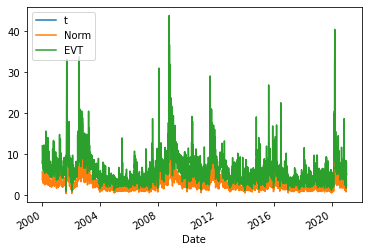

In [10]:
# transform the VaR forecasts for shocks to VaR forecasts for returns 
df_VaR_forecast_t_r = pd.DataFrame(VaR_forecast_t_s*RV, columns= ['t']) # Create datafram for plotting
VaR_forecast_t_r    = VaR_forecast_t_s*RV
VaR_forecast_norm_r = VaR_forecast_norm_s*RV
VaR_forecast_EVT_r  = VaR_forecast_EVT_s*RV

# Plot the VaR forecasts for the returns together in a plot 
df_VaR_forecast_t_r ['Norm'] = VaR_forecast_norm_r 
df_VaR_forecast_t_r ['EVT'] = VaR_forecast_EVT_r
df_VaR_forecast_t_r.plot()

### Q. 4.4

In [11]:
hit_series_t = np.where(R < -VaR_forecast_t_r , 1, 0) # Create a hit series. 1: if R < -VaR_forecast
per_exceed_t = sum(hit_series_t)/len(hit_series_t)   # Calculate the percentage of exceedence.
print('Percentage of exceedence (Standardized t distribution):', per_exceed_t)

hit_series_n = np.where(R < -VaR_forecast_norm_r, 1, 0) 
per_exceed_n = sum(hit_series_n)/len(hit_series_n)  
print('Percentage of exceedence (Normal distribution):', per_exceed_n)

hit_series_evt = np.where(R < -VaR_forecast_EVT_r, 1, 0)
per_exceed_evt = sum(hit_series_evt)/len(hit_series_evt)   
print('Percentage of exceedence (Extreme Value Theory):', per_exceed_evt)

Percentage of exceedence (Standardized t distribution): 0.0024262784621127288
Percentage of exceedence (Normal distribution): 0.002799552071668533
Percentage of exceedence (Extreme Value Theory): 0.0


Discussion: The percentage of exceedences is low for the VaR forecasts using the standardized t-distribution and normal distribution; there is likewise a 0.0% chance of the sudden occurence of a single large negative return, as captured by the Extreme Value Theory. In comparison to previous questions, where time-varying volatility is not used, the percentage of exceendences is relatively significantly larger (for the models with constant volatility). As such, by introducing time-varying volatility to VaR modeling, managers are able to enhance their measures of market risk. 

Another possible test to find differences between the models would be a stress test, which involves running the  models under crises for which a model was not inherently designed to adjust; this as such exposes problems with the model in relationship to methodological assumptions. To use constant volatility or time-varying volatility is one such methodological assumption.